In [3]:
import os
import glob
import random
import csv
import time

from PIL import Image
import torch
import torchvision.transforms as transforms
import visdom
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

In [34]:
class Pokemon(Dataset):

    def __init__(self, root, resize=32, mode="train", csv_filename='images.csv'):
        super(Pokemon, self).__init__()

        self.root = root
        self.resize = resize
        self.images = []
        self.labels = []

        self.name2label = {}
        for name in sorted(os.listdir(os.path.join(root))):
            if not os.path.isdir(os.path.join(root, name)):
                continue
            self.name2label[name] = len(self.name2label.keys())
        self.load_csv(csv_filename)
        
        if mode == 'train':
            self.images = self.images[:int(0.6*len(self.images))]
            self.labels = self.labels[:int(0.6*len(self.labels))]
        elif mode == 'val':
            self.images = self.images[int(0.6*len(self.images)):int(0.8*len(self.images))]
            self.labels = self.labels[int(0.6*len(self.labels)):int(0.8*len(self.labels))]
        elif mode == 'test':
            self.images = self.images[int(0.8*len(self.images)):]
            self.labels = self.labels[int(0.8*len(self.labels)):]
        else:
            print('请重新输入mode')

    def load_csv(self, filename):
        # 保存在CSV文件中
        if not os.path.exists(os.path.join(self.root, filename)):
            for name in self.name2label.keys():
                self.images += glob.glob(os.path.join(self.root, name, '*.png'))
                self.images += glob.glob(os.path.join(self.root, name, '*.jpg'))
                self.images += glob.glob(os.path.join(self.root, name, '*.jpeg'))
            random.shuffle(self.images)
            with open(os.path.join(self.root, filename), mode='w', newline='') as f:
                writer = csv.writer(f)
                for img in self.images:
                    name = img.split(os.sep)[-2]
                    label = self.name2label[name]
                    writer.writerow([img, label])
                
        with open(os.path.join(self.root, filename)) as f:
            reader = csv.reader(f)
            for row in reader:
                img, label = row
                label = int(label)
                self.images.append(img)
                self.labels.append(label)
        assert len(self.images) == len(self.labels)
        
    def __len__(self):
        return len(self.images)
    
    def denormalize(self, x_hat):
        
        mean=[0.435, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        mean = torch.tensor(mean).unsqueeze(1).unsqueeze(1)
        std = torch.tensor(std).unsqueeze(1).unsqueeze(1)
        
        x = x_hat * std + mean
        
        return x
    
    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        tf = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'),
            transforms.Resize((self.resize, self.resize)),
            transforms.RandomRotation(15),
            transforms.CenterCrop(self.resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.435, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        img = tf(img)
        label = torch.tensor(int(label))
        return img,label

In [4]:
db = Pokemon('D:\MyCode\dataset\pokeman', resize=224, mode="train")
viz = visdom.Visdom()
x, y = next(iter(db))
print('sample:', x.shape, y.shape, y)
viz.image(db.denormalize(x), win='sample_x', opts=dict(title='sample_x'))

# loader = DataLoader(db, batch_size=32, shuffle=True)
# for x, y in loader:
#     viz.images(db.denormalize(x), nrow=8, win='batch', opts=dict(title='batch'))
#     viz.text(str(y.numpy()), win='label', opts=dict(title='batch-y'))
#     time.sleep(10)

Setting up a new session...


sample: torch.Size([3, 224, 224]) torch.Size([]) tensor(1)


'sample_x'

In [35]:
def evalute(model, loader):
    correct = 0
    total = len(loader.dataset)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct += torch.eq(pred, y).sum().float().item()
    return correct/total

In [36]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [ ]:
batchsz = 32
lr = 1e-3
epochs = 10
# device = torch.device('cuda')
torch.manual_seed(1234)


def main():
    train_db = Pokemon('D:\MyCode\dataset\pokeman', 224, mode='train')
    val_db = Pokemon('D:\MyCode\dataset\pokeman', 224, mode='val')
    test_db = Pokemon('D:\MyCode\dataset\pokeman', 224, mode='test')
    
    train_loader = DataLoader(train_db, batch_size=batchsz, shuffle=True) # num_workers=2
    val_loader = DataLoader(val_db, batch_size=batchsz)
    test_loader = DataLoader(test_db, batch_size=batchsz)
    
    
    trained_model = resnet18(pretrained=True)#.to(device)
    model = nn.Sequential(*list(trained_model.children())[:-1],# 测试一下输出维度[b, 512, 1, 1]
                          Flatten(), #
                          nn.Linear(512, 5)
                         )
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criteon = nn.CrossEntropyLoss()
    
    best_acc = 0
    best_epoch = 0
    for epoch in range(epochs):
        
        for step, (x, y) in enumerate(train_loader):
            
            # x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criteon(logits, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % 2 == 0:
            val_acc = evalute(model, val_loader)
            if val_acc > best_acc:
                best_epoch = epoch
                best_acc = val_acc
                # 保存参数
                torch.save(model.state_dict(), 'best.mdl')
                
                
    # 加载参数               
    model.load_state_dict(torch.load('best.mdl'))   
    test_acc = evalute(model, test_loader)
main()

In [20]:
        train(train_db)

if epoch%10 == 0:
    val_acc = evaluate(val_db)

    if val_ass is the best:
        save_ckpt()

    if out_of_pratience():
        break
load_ckpt()
test_acc = evaluate(test_db)

SyntaxError: invalid syntax (3642243474.py, line 6)

In [16]:
a = [1, 2, 1, 1]
b = [3, 4]

In [17]:
a = a+b

In [18]:
a = "..\datas\category\2\149.png"
b = []

In [19]:
b.append(a)

In [20]:
b

['..\\datas\\category\x02\x0c9.png']

In [21]:
c = "..\datas\category\2\143.png"
b.append(c)

In [22]:
b

['..\\datas\\category\x02\x0c9.png', '..\\datas\\category\x02c.png']

In [23]:
import random

In [37]:
random.randint(1, 3)

3

In [95]:
a = [1, 2,10, 3, 5]
random.sample(a, 1)

[1]

In [96]:
b = sorted(a)

In [97]:
b

[1, 2, 3, 5, 10]

In [98]:
sum(b)

21

In [41]:
class ReaderClassfiedData:
    def __init__(self, root='D:\MyCodes\pythonProject\coated_tongue_color\datas\data2\category', mode='train', resize=224, random_seed=1):
        super(ReaderClassfiedData, self).__init__()
        self.resize = resize
        self.random_seed = random_seed
        self.mode = mode
        self.root = root
        self.train_images = []
        self.train_labels = []
        self.test_images = []
        self.test_labels = []
        self.category_num = len(os.listdir(root))
        self.tf1 = transforms.Compose([
            lambda x: Image.open(x).convert('RGB'),
            transforms.Resize((self.resize, self.resize)),
            transforms.RandomRotation(15),
            transforms.CenterCrop(self.resize),
            transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.435, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.tf2 = transforms.Compose([
            lambda x: Image.open(x).convert('RGB'),
            transforms.Resize((self.resize, self.resize)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.435, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        
        for dirs in os.listdir(self.root):
            temp_images = []
            temp_labels = []
            for img in os.listdir(os.path.join(self.root, dirs)):
                temp_images.append(os.path.join(self.root, dirs, img))
                temp_labels.append(int(dirs))
            random.seed(self.random_seed)
            random.shuffle(temp_images)
            self.train_images += temp_images[:int(0.7 * len(temp_images))]
            self.train_labels += temp_labels[:int(0.7 * len(temp_labels))]
            self.test_images += temp_images[int(0.7 * len(temp_images)):]
            self.test_labels += temp_labels[int(0.7 * len(temp_labels)):]
        random.seed(self.random_seed)
        random.shuffle(self.train_images)
        random.seed(self.random_seed)
        random.shuffle(self.train_labels)
        
    def __getitem__(self, idx):
        if self.mode == 'train':
            img, label = self.train_images[idx], self.train_labels[idx]
            img = self.tf1(img)
        else:
            img, label = self.test_images[idx], self.test_labels[idx]
            img = self.tf2(img)
        label = torch.tensor(int(label))
        return img, label


In [42]:
a = ReaderClassfiedData()

In [43]:
a[5]

(tensor([[[-1.8996, -1.8996, -1.8996,  ..., -1.8996, -1.8996, -1.8996],
          [-1.8996, -1.8996, -1.8996,  ..., -1.8996, -1.8996, -1.8996],
          [-1.8996, -1.8996, -1.8996,  ..., -1.8996, -1.8996, -1.8996],
          ...,
          [-1.8996, -1.8996, -1.8996,  ..., -1.8996, -1.8996, -1.8996],
          [-1.8996, -1.8996, -1.8996,  ..., -1.8996, -1.8996, -1.8996],
          [-1.8996, -1.8996, -1.8996,  ..., -1.8996, -1.8996, -1.8996]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [20]:
a = [1, 2, [56, 6]]

In [21]:
b = a

In [22]:
c

[1, 2, 4]

In [23]:
import copy

In [24]:
b

[1, 2, [56, 6]]

In [25]:
a.append(4)

In [29]:
a[2].append(3)

In [30]:
b

[1, 2, [56, 6, 3], 4]

In [31]:
c = a.copy()

In [32]:
c

[1, 2, [56, 6, 3], 4]

In [33]:
a.append(6)

In [34]:
c

[1, 2, [56, 6, 3], 4]

In [36]:
a[2].append(9)

In [37]:
c

[1, 2, [56, 6, 3, 9], 4]

In [38]:
a

[1, 2, [56, 6, 3, 9], 4, 6]

In [8]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [4]:
img = cv.imread(r'D:\\MyCodes\\pythonProject\\coated_tongue_color\\datas\\data2\\category\\4\\20220609194107-1.png')

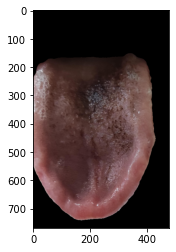

In [62]:
plt.imshow(img[:,:,::-1])

In [5]:
cv.imshow(r'D:\\MyCodes\\pythonProject\\coated_tongue_color\\datas\\data2\\category\\4\\20220609194107-1.png', img)
cv.waitKey(0)
cv.destroyAllWindows()

In [65]:
img.shape

(768, 480, 3)

In [9]:
kernel = np.ones((30, 30), np.uint8)
img2 = cv.erode(img, kernel)

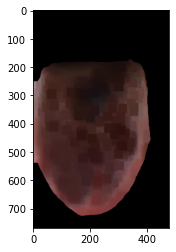

In [10]:
plt.imshow(img2[:,:,::-1])

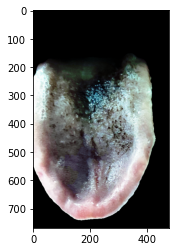

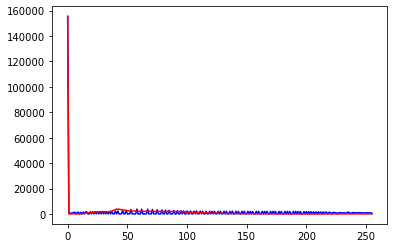

In [3]:
import cv2 as cv 
import numpy as np
from matplotlib import pyplot as plt
 
test=cv.imread(r'D:\\MyCodes\\pythonProject\\coated_tongue_color\\datas\\data2\\category\\4\\20220609194107-1.png')
 
B,G,R = cv.split(test) #get single 8-bits channel
EB=cv.equalizeHist(B)
EG=cv.equalizeHist(G)
ER=cv.equalizeHist(R)
equal_test=cv.merge((EB,EG,ER))  #merge it back
plt.imshow(test[:,:,::-1])
plt.imshow(equal_test[:,:,::-1])
plt.show()
hist_EB=cv.calcHist([EB],[0],None,[256],[0,256]) 
hist_EG=cv.calcHist([EG],[0],None,[256],[0,256]) 
hist_ER=cv.calcHist([ER],[0],None,[256],[0,256]) 
hist_b=cv.calcHist([B],[0],None,[256],[0,256]) 
plt.plot(hist_EB,'b');
plt.plot(hist_b,'r');
plt.show()

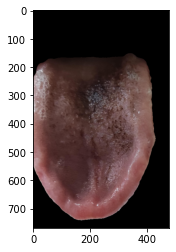

In [4]:
plt.imshow(test[:,:,::-1])

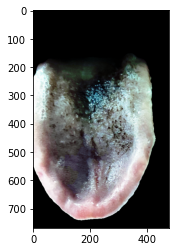

In [5]:
plt.imshow(equal_test[:,:,::-1])